<a href="https://colab.research.google.com/github/Nabila310/2025_Visi-Komputer_TI2A/blob/main/Jobsheet_03_Teknik_Regresi_Gambar_D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload()  # pilih file kaggle.json dari komputer Anda


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nabilaramadani","key":"9783115b33e8e7597deb58fbc73c83d9"}'}

In [2]:
import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")


✅ Kaggle API siap digunakan.


In [3]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


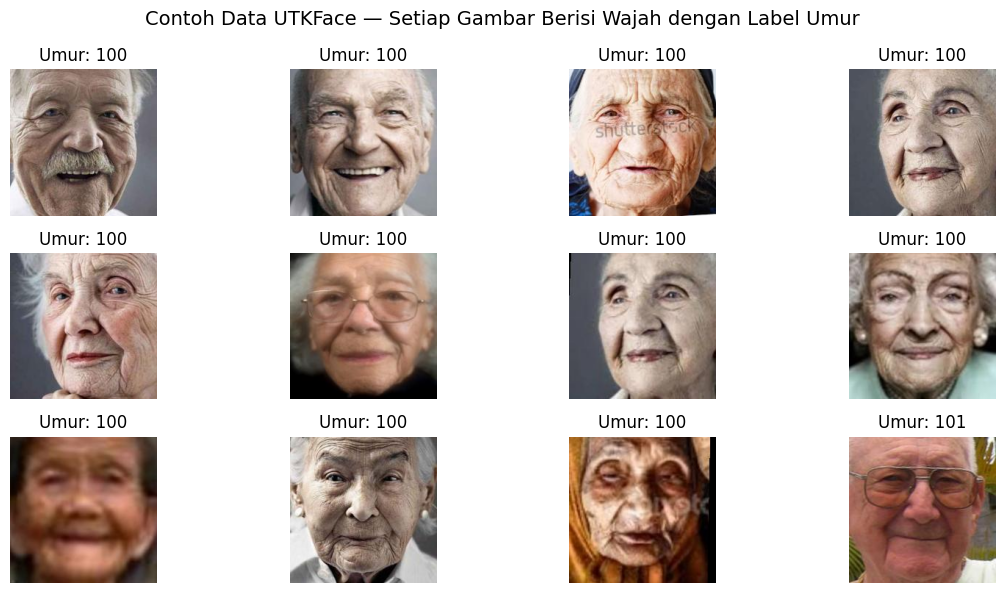

In [4]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()


In [5]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")


✅ Dataset siap dilatih.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

model.summary()


Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 56s 129ms/step - loss: 347.4775 - mae: 13.6763 - val_loss: 160.8671 - val_mae: 9.6784 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 46ms/step - loss: 155.3475 - mae: 9.2825 - val_loss: 146.9366 - val_mae: 9.1031 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 145.1244 - mae: 8.8734 - val_loss: 145.1833 - val_mae: 9.0677 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 140.6180 - mae: 8.7234 - val_loss: 140.5310 - val_mae: 8.8337 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 139.3961 - mae: 8.6817 - val_loss: 138.9986 - val_mae: 8.7633 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 135.4604 - mae: 8.5163 - val_loss: 137.4075 - val_mae: 8.7000 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - loss: 133.5006 - mae: 8.4549 - val_loss: 137.3452 - va

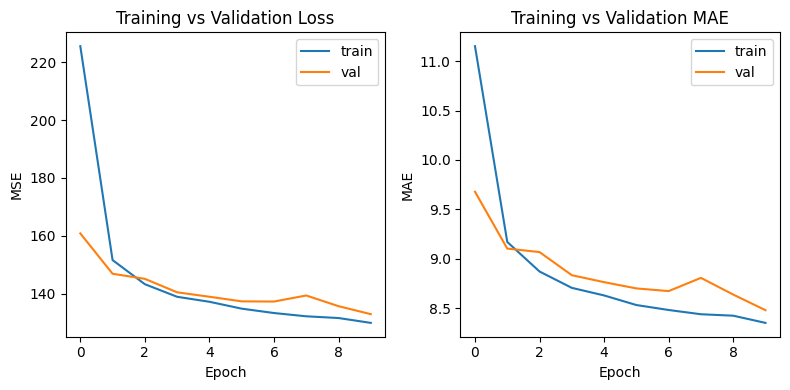

In [7]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 96ms/step - loss: 188.5394 - mae: 10.0755 - val_loss: 166.0641 - val_mae: 9.3360 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 79.3518 - mae: 6.5670 - val_loss: 122.5593 - val_mae: 8.0517 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 52.5401 - mae: 5.4333 - val_loss: 106.4929 - val_mae: 7.6316 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 38.0883 - mae: 4.6830 - val_loss: 102.5706 - val_mae: 7.4593 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 31.2568 - mae: 4.2047 - val_loss: 106.5014 - val_mae: 7.5464 - learning_rate: 1.0000e-04


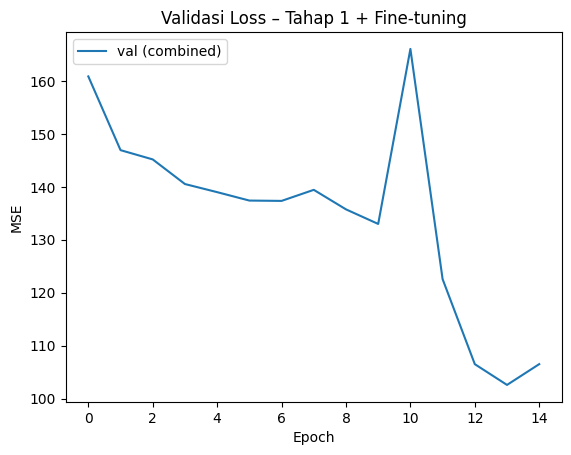

In [8]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


MAE  = 7.46 tahun
RMSE = 10.13 tahun
R²   = 0.742


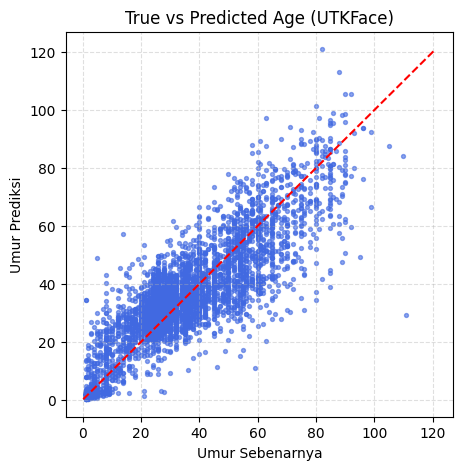

In [9]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


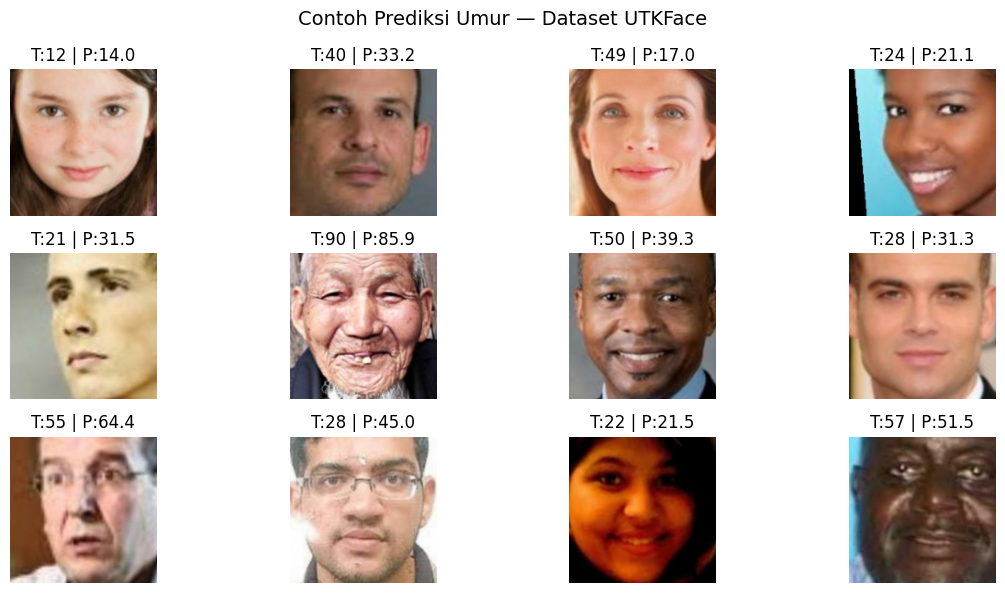

In [10]:
import random

sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12, 6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


Penugasan 3

In [ ]:

import os
from google.colab import files
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


model_path = '/content/model_prediksi_usia.h5'

if not os.path.exists(model_path):
    print("⚠️ File model_prediksi_usia.h5 belum ditemukan.")
    print("📤 Silakan upload model hasil praktikum D2 (file .h5)")
    uploaded = files.upload()
    model_path = '/content/model_prediksi_usia.h5'


model_usia = load_model(model_path)
print("✅ Model prediksi usia berhasil dimuat.\n")


print("📤 Silakan upload foto pribadi kamu (ila.jpeg)")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]


IMG_SIZE = 200
img = Image.open(image_path).convert('RGB')
img_resized = img.resize((IMG_SIZE, IMG_SIZE))
img_array = np.array(img_resized) / 255.0
img_tensor = np.expand_dims(img_array, axis=0)

predicted_age = model_usia.predict(img_tensor, verbose=0)[0][0]


plt.figure(figsize=(5,5))
plt.imshow(img_resized)
plt.title(f"Prediksi Usia: {predicted_age:.1f} tahun", fontsize=12)
plt.axis('off')
plt.show()

print(f"🎯 Hasil Prediksi Usia dari Foto Pribadi: {predicted_age:.1f} tahun")


⚠️ File model_prediksi_usia.h5 belum ditemukan.
📤 Silakan upload model hasil praktikum D2 (file .h5)
